In [1]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import models
from PIL import Image
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install ultralytics

In [3]:
# опишем архитектуру StackedHourglassNetwork для инициализации модели для весов
# все тоже самое, что и в соответствующем ноутбуке
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)
        mid_channels = out_channels // 2

        self.conv1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += residual

        return F.relu(x)


class Hourglass(nn.Module):
    def __init__(self, in_channels, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.downsample = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)


        self.down_blocks = nn.ModuleList([ResidualBlock(in_channels, in_channels) for _ in range(depth)])
        self.up_blocks = nn.ModuleList([ResidualBlock(in_channels, in_channels) for _ in range(depth)])
        self.bottom_block = ResidualBlock(in_channels, in_channels)

    def forward(self, x):
        skip_connections = []

        for down_block in self.down_blocks:
            x = down_block(x)
            skip_connections.append(x)
            x = self.downsample(x)

        x = self.bottom_block(x)

        for up_block in self.up_blocks:
            x = self.upsample(x)
            x = x + skip_connections.pop()
            x = up_block(x)

        return x

class StackedHourglassNetwork(nn.Module):
    def __init__(self, in_channels, num_keypoints, num_stacks=4, depth=3):
        super(StackedHourglassNetwork, self).__init__()
        self.num_stacks = num_stacks

        self.preprocess = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128, 128)
        )

        self.hourglasses = nn.ModuleList([
            Hourglass(128, depth=depth) for _ in range(num_stacks)
        ])

        self.intermediate_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=1),
            ) for _ in range(num_stacks - 1)
        ])

        self.output_convs = nn.ModuleList([
            nn.Conv2d(128, num_keypoints, kernel_size=1) for _ in range(num_stacks)
        ])

        self.skip_convs = nn.ModuleList([
            nn.Conv2d(num_keypoints, 128, kernel_size=1, bias=False)
            for _ in range(num_stacks - 1)
        ])

    def forward(self, x):
        x = self.preprocess(x)
        outputs = []

        for i in range(self.num_stacks):
            x = self.hourglasses[i](x)

            output = self.output_convs[i](x)
            outputs.append(output)

            if i < self.num_stacks - 1:
                inter = self.intermediate_convs[i](x)
                skip = self.skip_convs[i](output)
                x = x + inter + skip

        return outputs

In [4]:
from ultralytics import YOLO

# подгрузим наши модели
# детектор лиц
detector = YOLO("yolov10n-face.pt").to('cpu')

# детектор ключевых точек
landmarks_detector = StackedHourglassNetwork(in_channels=3, num_keypoints=5, num_stacks=3)
landmarks_detector.load_state_dict(torch.load("best_stacked_hourglass_model.pth", map_location=torch.device('cpu')))

# классификаторы
cross_entropy_classificator = models.resnet18(pretrained=True)
cross_entropy_classificator.fc = nn.Linear(512, 200)
cross_entropy_classificator.load_state_dict(torch.load('best_classification_model_with_cross_entropy.pth', map_location=torch.device('cpu')))

arc_face_classificator = models.resnet18(pretrained=True)
arc_face_classificator.fc = nn.Identity()
arc_face_classificator.load_state_dict(torch.load("best_classification_model_with_arc_face.pth", map_location=torch.device('cpu')))

embedding_size = 256
triplet_loss_classificator = models.resnet18(pretrained=True)
triplet_loss_classificator.fc = nn.Sequential(
    nn.Linear(512, embedding_size),
    nn.BatchNorm1d(embedding_size),
    nn.ReLU()
)
triplet_loss_classificator.load_state_dict(torch.load('best_classification_model_with_triplet_loss.pth', map_location=torch.device('cpu')))

semi_hard_mining_triplet_loss_classificator = models.resnet18(pretrained=True)
semi_hard_mining_triplet_loss_classificator.fc = nn.Sequential(
    nn.Linear(512, embedding_size),
    nn.BatchNorm1d(embedding_size),
    nn.ReLU()
)
semi_hard_mining_triplet_loss_classificator.load_state_dict(torch.load('best_classification_model_with_semi_hard_mining_triplet_loss.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
# возьму для demo из оригинального датасета 3 картинки: 1-ая соответствует одному человеку, 2-ая и 3-я другому
names = ['000007.jpg', '000009.jpg', '064398.jpg']

# покажем что их действительно нет в данных, на которых обучались модели
filtered_csv = "identity_CelebA_mini.csv"
filtered_df = pd.read_csv(filtered_csv)

filtered_df[filtered_df['image_id'].isin(names)]

,image_id,id


In [8]:
# папка для картинок для демонстрации, я ее добавил вместе с содержимым в гитхаб
images_for_demo_path = 'images_for_demo'

In [9]:
# подгрузка картинки
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

# рисование картинок (выровнено для трех)
def show_images(images):
    ig, axes = plt.subplots(1, 3, figsize=(10, 7))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

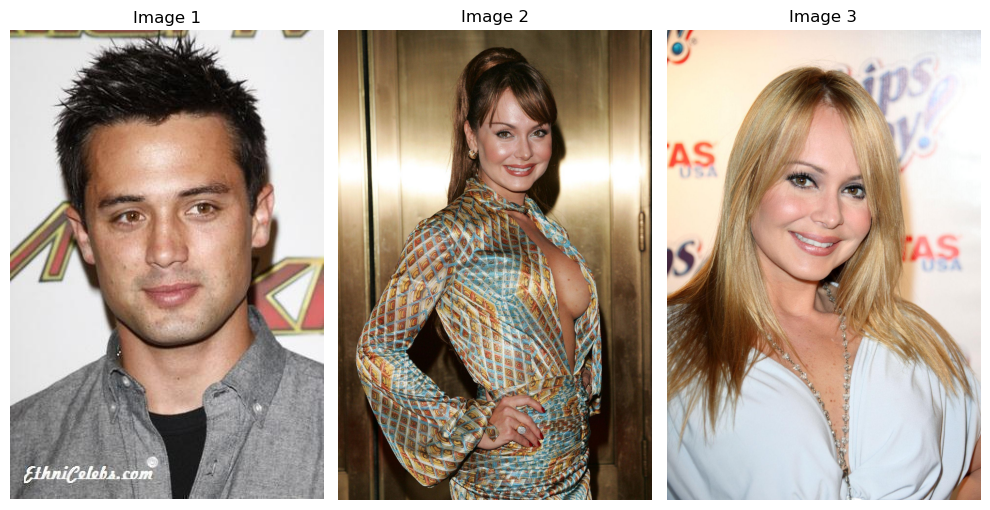

In [10]:
images_pathes = [os.path.join(images_for_demo_path, name) for name in names]
images = []
for images_pathe in images_pathes:
    img = load_image(images_pathe)
    images.append(img)

show_images(images)

In [11]:
# функция для перевода хитмапов в ключевые точки, такая же как и в ноутбуке по Stacked_Hourglass_Network 
def heatmaps_to_keypoints(heatmaps):
    keypoints = []
    for heatmap in heatmaps:
        y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        keypoints.append((x, y))
    return np.array(keypoints)

# для рисования картинки с ключевыми точками, такая же как и в ноутбуке по Stacked_Hourglass_Network 
def plot_image_with_keypoints(image, keypoints):
    plt.imshow(image)

    for (x, y) in keypoints:
        plt.scatter(x, y, s=50, c='red', marker='o')

    plt.title("Image with keypoints")
    plt.show()

In [12]:
# таргет поинты для выравнивания
target_points = np.array([
    [18, 24],  
    [48, 24],  
    [40, 38],  
    [22, 48],  
    [44, 48] 
])

In [13]:
# датасет для обработки картинок: загружаем, обрезаем, выравниваем, считаем эмбединги
# кое-где оставлены закомментаренные строки, для того, чтобы посмотреть, что опр этап работает
class MyFaceNet(Dataset):
    def __init__(self, images_pathes, detector, landmarks_detector, classificator):
        self.images_pathes = images_pathes
        self.detector = detector
        self.landmarks_detector = landmarks_detector
        self.classificator = classificator
        
    def __len__(self):
        return len(self.images_pathes)
        
    def __getitem__(self, idx):
        image_path = self.images_pathes[idx]
        image = self.load_image(image_path)
#         plt.imshow(image)
        bboxes = self.get_bboxes(image)
        cropped_image = self.crop_and_recize(image, bboxes, 64)
#         plt.imshow(cropped_image)
        aligned_image = self.get_aligned_image(cropped_image)
        image_tenzor_for_classificator = self.prepare_for_classificator(aligned_image)
        
        batch = image_tenzor_for_classificator.unsqueeze(0)
        
        self.classificator.eval()
        with torch.no_grad():
            embeddings = self.classificator(batch)
        
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        return embeddings
        
    
    def get_bboxes(self, image):
        results = self.detector(image)
        results = results[0][0]
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
        
        bboxes = [x1.item(), y1.item(), x2.item(), y2.item()]
        bboxes = np.array(bboxes).astype(int)
        
        return bboxes
    
    
    def crop_and_recize(self, image, bboxes, img_size):
        x_min, y_min, x_max, y_max = bboxes    
        cropped_image = image[y_min:y_max, x_min:x_max]
        scale_x = img_size / (x_max - x_min)
        scale_y = img_size / (y_max - y_min)
        cropped_image = cv2.resize(cropped_image, (img_size, img_size))
        
        return cropped_image
    
    def prepare_image_for_landmarks_detector(self, image):
        image = image / 255.0
        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    
    def get_aligned_image(self, image):
        image_tenzor_for_landmark = self.prepare_image_for_landmarks_detector(image)  
        batch = image_tenzor_for_landmark.unsqueeze(0)
        with torch.no_grad():
            outputs = self.landmarks_detector(batch)    
            heatmaps = outputs[-1]
            heatmap = heatmaps[0].numpy()
            pred_keypoints = heatmaps_to_keypoints(heatmap)
#             plot_image_with_keypoints(image, pred_keypoints)
            aligned_image = self.align_image(image, pred_keypoints, target_points)
#             plt.imshow(aligned_image)
    
        return aligned_image
    
    def prepare_for_classificator(self, image):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        image = transform(image)
        return image
        
    
    def align_image(self, image, keypoints, target_points):
        affine_matrix, _ = cv2.estimateAffinePartial2D(keypoints[0:2], target_points[0:2]) # только по глазам
        aligned_image = cv2.warpAffine(image, affine_matrix, (64, 64))

        return aligned_image
    
    def load_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img

In [14]:
images_pathes = ['images_for_demo/000007.jpg', 'images_for_demo/000009.jpg', 'images_for_demo/064398.jpg']
# напомню что 1-ая соответствует одному человеку, 2-ая и 3-я - другому

In [15]:
# посмотрим для cross_entropy_classificator
my_face_net = MyFaceNet(images_pathes, detector, landmarks_detector, cross_entropy_classificator)
embeding0 = my_face_net[0]
embeding1 = my_face_net[1]
embeding2 = my_face_net[2]
print('сходство между 1 и 3', F.cosine_similarity(embeding0, embeding2, dim=1).item())
print('сходство между 1 и 2', F.cosine_similarity(embeding0, embeding1, dim=1).item())
print('сходство между 2 и 3 (один человек)', F.cosine_similarity(embeding1, embeding2, dim=1).item())
print('сходство между одними и теми же картинками', F.cosine_similarity(embeding1, embeding1, dim=1).item())


0: 640x448 1 face, 97.6ms
Speed: 4.9ms preprocess, 97.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 46.6ms
Speed: 2.5ms preprocess, 46.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 46.3ms
Speed: 2.5ms preprocess, 46.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)
сходство между 1 и 3 0.7250533699989319
сходство между 1 и 2 0.7823220491409302
сходство между 2 и 3 (один человек) 0.9237686395645142
сходство между одними и теми же картинками 1.0000001192092896


In [16]:
# посмотрим для arc_face_classificator
my_face_net = MyFaceNet(images_pathes, detector, landmarks_detector, arc_face_classificator)
embeding0 = my_face_net[0]
embeding1 = my_face_net[1]
embeding2 = my_face_net[2]
print('сходство между 1 и 3', F.cosine_similarity(embeding0, embeding2, dim=1).item())
print('сходство между 1 и 2', F.cosine_similarity(embeding0, embeding1, dim=1).item())
print('сходство между 2 и 3 (один человек)', F.cosine_similarity(embeding1, embeding2, dim=1).item())
print('сходство между одними и теми же картинками', F.cosine_similarity(embeding1, embeding1, dim=1).item())


0: 640x448 1 face, 66.1ms
Speed: 5.1ms preprocess, 66.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 45.0ms
Speed: 2.5ms preprocess, 45.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 47.2ms
Speed: 2.4ms preprocess, 47.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)
сходство между 1 и 3 0.5609358549118042
сходство между 1 и 2 0.5645632743835449
сходство между 2 и 3 (один человек) 0.6692413091659546
сходство между одними и теми же картинками 1.0


In [17]:
# посмотрим для triplet_loss_classificator
my_face_net = MyFaceNet(images_pathes, detector, landmarks_detector, triplet_loss_classificator)
embeding0 = my_face_net[0]
embeding1 = my_face_net[1]
embeding2 = my_face_net[2]
print('сходство между 1 и 3', F.cosine_similarity(embeding0, embeding2, dim=1).item())
print('сходство между 1 и 2', F.cosine_similarity(embeding0, embeding1, dim=1).item())
print('сходство между 2 и 3 (один человек)', F.cosine_similarity(embeding1, embeding2, dim=1).item())
print('сходство между одними и теми же картинками', F.cosine_similarity(embeding1, embeding1, dim=1).item())


0: 640x448 1 face, 58.5ms
Speed: 3.1ms preprocess, 58.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 51.2ms
Speed: 2.6ms preprocess, 51.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 44.5ms
Speed: 2.5ms preprocess, 44.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)
сходство между 1 и 3 0.3534703850746155
сходство между 1 и 2 0.19785504043102264
сходство между 2 и 3 (один человек) 0.6023855209350586
сходство между одними и теми же картинками 1.0000001192092896


In [19]:
# посмотрим для semi_hard_mining_triplet_loss_classificator
my_face_net = MyFaceNet(images_pathes, detector, landmarks_detector, semi_hard_mining_triplet_loss_classificator)
embeding0 = my_face_net[0]
embeding1 = my_face_net[1]
embeding2 = my_face_net[2]
print('сходство между 1 и 3', F.cosine_similarity(embeding0, embeding2, dim=1).item())
print('сходство между 1 и 2', F.cosine_similarity(embeding0, embeding1, dim=1).item())
print('сходство между 2 и 3 (один человек)', F.cosine_similarity(embeding1, embeding2, dim=1).item())
print('сходство между одними и теми же картинками', F.cosine_similarity(embeding1, embeding1, dim=1).item())


0: 640x448 1 face, 63.9ms
Speed: 4.8ms preprocess, 63.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 51.2ms
Speed: 2.5ms preprocess, 51.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 face, 44.8ms
Speed: 3.0ms preprocess, 44.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)
сходство между 1 и 3 0.11170855164527893
сходство между 1 и 2 0.32100340723991394
сходство между 2 и 3 (один человек) 0.41375061869621277
сходство между одними и теми же картинками 1.0


Все классификаторы корректно отличают одного человека от другого. У cross_entropy_classificator самое высокое сходство между разными картинками одного человека, у triplet_loss_classificator самая большая разница между картинками разных людей.